# Image region-level saliency using VGG-16 Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `torch`, `torch.nn`, `torch.nn.functional` and `torchvision`.

Our `utils` module provides an image preparation function.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
import skimage.transform, skimage.util

import utils
import imagenet_classes

torch_device = torch.device('cuda:0')

## Load an image to process

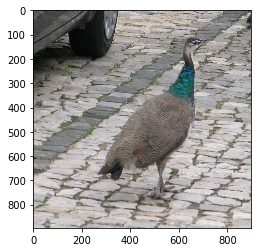

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Load the model

To save some time, we are going to use the `VGG16Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [4]:
# Build it, requesting that the pre-trained model weights are loaded
# The call to the `to` method moves it onto the GPU
vgg16_net = torchvision.models.vgg.vgg16(pretrained=True).to(torch_device)

# Call the eval() method; we are not training
vgg16_net.eval()

# Also, set a variable 
MODEL_MEAN = np.array([0.485, 0.456, 0.406])
MODEL_STD = np.array([0.229, 0.224, 0.225])

Create the input variable, generate the probability expression and construct a Theano function that we can call:

In [5]:
def f_classify_images(image_batch):
    """
    image_batch - images as a NumPy 4D array - (sample, channel, height, width)
    return: probabilities - (sample, class)
    """
    # We don't need gradients here as we are only performing inference/prediction
    with torch.no_grad():
        x = torch.tensor(image_batch, dtype=torch.float, device=torch_device)
        logits = vgg16_net(x)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    

Prepare the image, scaling to 224x224:

In [6]:
raw_img, img_for_vgg = utils.prepare_image(img, MODEL_MEAN, MODEL_STD, image_size=224)

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Discover the salient regions of the image - simple method
The simplest method to determine if part of an image is *salient* is to mask it out and evaluate the effect on the predicted class probability. The idea was briefly described by Felix Lau in http://felixlaumon.github.io/2015/01/08/kaggle-right-whale.html. The approach that we will use is a little different; while Lau slid a black box over the image we will slide a box of value 0.0 over the image, where the pixel values already have 0-mean, so the actual box colour will be an off-grey.

This approach to image saliency uses the existing unmodified network. We will generate a set of images, each one with a different part masked out. We generate these images by sliding the mask over the image in both the vertical and horizontal axes and generating a new image for each position. We then use the network to generate a prediction for each masked image and use the output to determine saliency.

In [7]:
MASK_SHAPE = 64,64
STEP_SHAPE = 16,16

n_y = 0
masked_images = []
for i in range(0, img_for_vgg.shape[2] - MASK_SHAPE[0] + 1, STEP_SHAPE[0]):
    for j in range(0, img_for_vgg.shape[3] - MASK_SHAPE[1] + 1, STEP_SHAPE[1]):
        # Take a copy of the image
        masked_img = img_for_vgg.copy()
        # Set the masked region to 0
        masked_img[:,:,i:i+MASK_SHAPE[0], j:j+MASK_SHAPE[1]] = 0.0
        masked_images.append(masked_img)
    n_y += 1

masked_images = np.concatenate(masked_images, axis=0)
pred_shape = n_y, masked_images.shape[0] // n_y
print(masked_images.shape, pred_shape)

(121, 3, 224, 224) (11, 11)


Lets take a look at a few of the masked images:

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


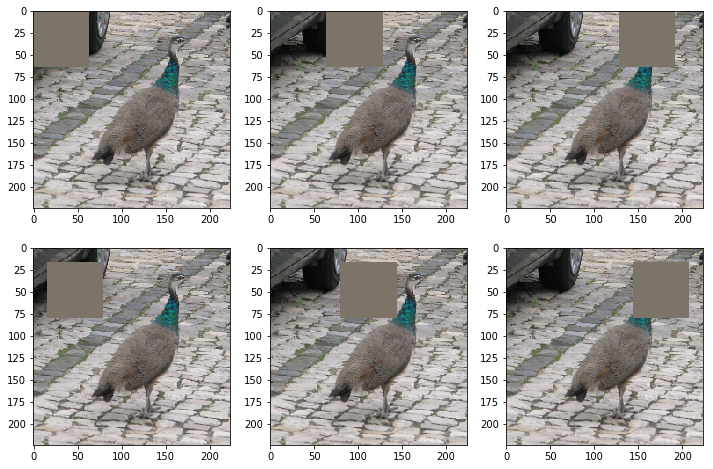

In [8]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(utils.inv_prepare_image(masked_images[i*4], MODEL_MEAN, MODEL_STD))
plt.show()

### Predict probabilities for the unmasked image and the masked images

The original unmasked image:

In [9]:
# First, generate a prediction for the unmasked image:
pred_prob_unmasked = f_classify_images(img_for_vgg)
# Get the predicted probability of the unmasked image being a peacock:
unmasked_peacock_prob = pred_prob_unmasked[0,84]
print('Unmasked image: probability of peacock {:.2%}'.format(unmasked_peacock_prob))

Unmasked image: probability of peacock 99.97%


Generate predictions for the masked images in batches of 16:

In [10]:
t1 = time.time()
pred_prob_masked_flat = [f_classify_images(masked_images[i:i+16,:,:,:]) for i in range(0, masked_images.shape[0], 16)]
t2 = time.time()
pred_prob_masked_flat = np.concatenate(pred_prob_masked_flat, axis=0)

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(masked_images.shape[0],
                                                                                       t2-t1, pred_prob_masked_flat.shape))

Prediction for 121 images took 0.33s, resulting in an array of shape(121, 1000)


So we can visualise the predictions, lets reshape the predictions back into two dimensions. The variable `pred_shape` contains the 2D shape of the predicted output:

In [11]:
pred_prob_masked_2d = pred_prob_masked_flat.reshape(pred_shape + (1000,))
print('Predicted probability 2D shape {}, p(peacock) min {:.3f} max {:.3f}'.format(
        pred_prob_masked_2d.shape, pred_prob_masked_2d[:,:,84].min(), pred_prob_masked_2d[:,:,84].max()))

Predicted probability 2D shape (11, 11, 1000), p(peacock) min 0.484 max 1.000


### Generate saliency image

Generate a saliency image by computing the change in probabilty caused by masking.

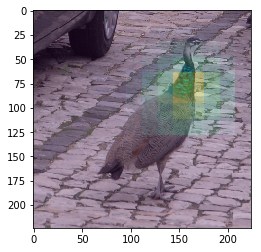

In [12]:
# Saliency image, same size as original
d_prob_2d = np.zeros(img_for_vgg.shape[2:])
for i in range(pred_prob_masked_2d.shape[0]):
    y = i * STEP_SHAPE[0]
    for j in range(pred_prob_masked_2d.shape[1]):
        x = j * STEP_SHAPE[1]
        # Compute the difference in probability
        d_prob = unmasked_peacock_prob - pred_prob_masked_2d[i,j,84]
        # Accumulate in the saliency image
        d_prob_2d[y:y+MASK_SHAPE[0], x:x+MASK_SHAPE[1]] += d_prob
# Compute the coverage so the number of samples accumulated...
saliency_coverage = MASK_SHAPE[0] * MASK_SHAPE[1] / (STEP_SHAPE[0] * STEP_SHAPE[1])
# ... and average
saliency_2d = d_prob_2d / saliency_coverage
plt.imshow(raw_img)
plt.imshow(saliency_2d, alpha=0.25)
plt.show()

## Lets wrap it up in a function

In [13]:
def visualise_block_saliency(img_for_vgg, mask_shape, step_shape, saliency_class=None):
    # Build the list of masked images
    n_y = 0
    masked_images = []
    for i in range(0, img_for_vgg.shape[2] - mask_shape[0] + 1, step_shape[0]):
        for j in range(0, img_for_vgg.shape[3] - mask_shape[1] + 1, step_shape[1]):
            # Take a copy of the image
            masked_img = img_for_vgg.copy()
            # Set the masked region to 0
            masked_img[:,:,i:i+mask_shape[0], j:j+mask_shape[1]] = 0.0
            masked_images.append(masked_img)
        n_y += 1

    masked_images = np.concatenate(masked_images, axis=0)
    pred_shape = n_y, masked_images.shape[0] // n_y
    
    # First, generate a prediction for the unmasked image:
    pred_prob_unmasked = f_classify_images(img_for_vgg)
    
    if saliency_class is None:
        saliency_class = np.argmax(pred_prob_unmasked, axis=1)[0]
        
    sal_class_name = imagenet_classes.IMAGENET_CLASSES[saliency_class]
    
    # Get the predicted probability of the unmasked image being a peacock:
    pred_prob_cls_unmasked = pred_prob_unmasked[0,saliency_class]
    print('Unmasked image: probability of {} {:.2%}'.format(sal_class_name, pred_prob_cls_unmasked))    

    # Generate probability predictions for masked images in batches of 16
    t1 = time.time()
    pred_prob_masked_flat = [f_classify_images(masked_images[i:i+16,:,:,:]) for i in range(0, masked_images.shape[0], 16)]
    t2 = time.time()
    pred_prob_masked_flat = np.concatenate(pred_prob_masked_flat, axis=0)

    print('Prediction for {} masked images took {:.2f}s, resulting in an array of shape{}'.format(masked_images.shape[0],
                                                                                           t2-t1, pred_prob_masked_flat.shape))
    # Reshanem
    pred_prob_masked_2d = pred_prob_masked_flat.reshape(pred_shape + (1000,))
    print('Predicted probability 2D shape {}, p({}) min {:.2%} max {:.2%}'.format(
            pred_prob_masked_2d.shape, sal_class_name,
            pred_prob_masked_2d[:,:,saliency_class].min(), pred_prob_masked_2d[:,:,saliency_class].max()))    

    # Saliency image, same size as original
    d_prob_2d = np.zeros(img_for_vgg.shape[2:])
    for i in range(pred_prob_masked_2d.shape[0]):
        y = i * step_shape[0]
        for j in range(pred_prob_masked_2d.shape[1]):
            x = j * step_shape[1]
            # Compute the difference in probability
            d_prob = unmasked_peacock_prob - pred_prob_masked_2d[i,j,saliency_class]
            # Accumulate in the saliency image
            d_prob_2d[y:y+mask_shape[0], x:x+mask_shape[1]] += d_prob
    # Compute the coverage so the number of samples accumulated...
    saliency_coverage = mask_shape[0] * mask_shape[1] / (step_shape[0] * step_shape[1])
    # ... and average
    saliency_2d = d_prob_2d / saliency_coverage
    plt.imshow(raw_img)
    plt.imshow(saliency_2d, alpha=0.25)
    plt.show()

Unmasked image: probability of peacock 99.97%
Prediction for 169 masked images took 0.39s, resulting in an array of shape(169, 1000)
Predicted probability 2D shape (13, 13, 1000), p(peacock) min 71.35% max 99.99%


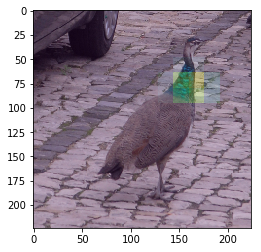

In [14]:
visualise_block_saliency(img_for_vgg, (32,32), (16,16))

Unmasked image: probability of peacock 99.97%
Prediction for 144 masked images took 0.33s, resulting in an array of shape(144, 1000)
Predicted probability 2D shape (12, 12, 1000), p(peacock) min 68.54% max 99.99%


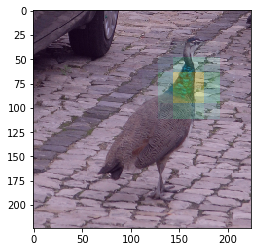

In [15]:
visualise_block_saliency(img_for_vgg, (48,48), (16,16))

Unmasked image: probability of peacock 99.97%
Prediction for 121 masked images took 0.30s, resulting in an array of shape(121, 1000)
Predicted probability 2D shape (11, 11, 1000), p(peacock) min 48.42% max 99.99%


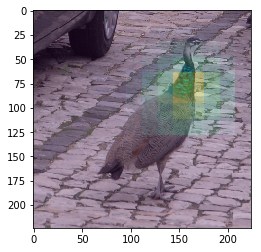

In [16]:
visualise_block_saliency(img_for_vgg, (64,64), (16,16))

Unmasked image: probability of peacock 99.97%
Prediction for 100 masked images took 0.23s, resulting in an array of shape(100, 1000)
Predicted probability 2D shape (10, 10, 1000), p(peacock) min 6.88% max 99.99%


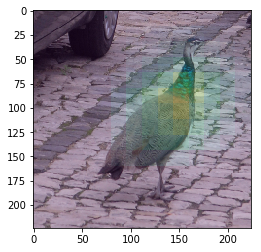

In [17]:
visualise_block_saliency(img_for_vgg, (80,80), (16,16))

Unmasked image: probability of peacock 99.97%
Prediction for 81 masked images took 0.20s, resulting in an array of shape(81, 1000)
Predicted probability 2D shape (9, 9, 1000), p(peacock) min 0.09% max 99.99%


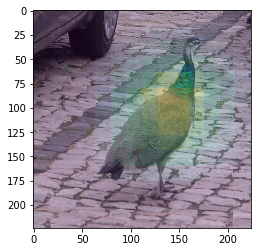

In [18]:
visualise_block_saliency(img_for_vgg, (96,96), (16,16))